In [26]:
import os
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
file = os.path.join("data", "bare_all.csv")

data = pd.read_csv(file, delimiter='\t')

In [237]:
# take a sample of records to play with
small_num = 10_000
sample = data[:small_num]

text = sample.text
label = sample.label

text_train = text[:small_num//2]
text_test = text[small_num//2:]
label_train = label[:small_num//2]
label_test = label[small_num//2:]

In [238]:
# compute class weights for keras (obtained from the whole of train sample)

n_classes = len(np.unique(label_train))

from sklearn.utils.class_weight import compute_class_weight
compute_class_weight('balanced', np.unique(label), label)  # ~ 1 / np.unique(label, return_counts=True)[1]

array([ 1.28998968,  0.71530758,  0.2763958 , 13.77410468, 26.04166667,
       10.22494888])

In [260]:
# one hot encode the (single) lables

onehot_e = OneHotEncoder(handle_unknown='ignore')
y_train = onehot_e.fit_transform(np.array(label_train).reshape(-1,1))

In [261]:
y_train.todense()

matrix([[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])

In [241]:
# mask or flag LaTeX expression with a word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

    # self.pattern = r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})"
    # why does it differ from  r'(\$.+?\$)' ?
    
class DeLaTeX(BaseEstimator, TransformerMixin):
    
    def __init__(self, behave=None, pattern=r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})", repl = ' _LATEX_ '):
        self.repl = ' _LATEX_ '
        self.pattern = pattern
        self.behave = behave
        
        if self.behave == 'mask':
            self.repl = ' _LATEX_ '
        elif self.behave == 'flag':
            self.repl = r' _LATEX_ \1'
        return None

    def fit(self, X, y=None):
        if not isinstance(X, pd.core.series.Series):
            raise TypeError("The data must be a pandas Series of strings")
        return self

    def transform(self, X):
        if self.behave:
            return X.str.replace(self.pattern, self.repl)
        return X
            

In [247]:
delatex = DeLaTeX(behave='mask')
notex_text_train = delatex.fit_transform(text_train)

In [243]:
# see how many unique words are there globally (unique_words)
# and how many words are in the longest text (max_word_count)
# save the annoyingly confusing integers to feed later into keras

count_v = CountVectorizer(min_df = 1, strip_accents='unicode')
word_counts_train = count_v.fit_transform(notex_text_train)

unique_words = word_counts_train.shape[1]
num_words = unique_words + 1
max_word_count = np.max(np.sum(word_counts_train, axis=1))
padded_length = int(1.05*max_word_count)

print(f"Counted {unique_words} unique words in the whole train dataset.")
print(f"Take numbers 1 to 'num_words'={num_words} as numerical labels for the unique words, and 0 for 'silence'.")
print(f"A single record has at most {max_word_count} words.")
print(f"The text will be tokenized into sequences of numerical labels and put into arrays of length \
'padded_length'={padded_length} left-padded with zeros. The extra 5% of length is there in case a longer text \
would need to be tokenized and classified later (e.g. from a test dataset).")

Counted 25685 unique words in the whole train dataset.
Take numbers 1 to 'num_words'=25686 as numerical labels for the unique words, and 0 for 'silence'.
A single record has at most 434 words.
The text will be tokenized into sequences of numerical labels and put into arrays of length 'padded_length'=455 left-padded with zeros. The extra 5% of length is there in case a longer text would need to be tokenized and classified later (e.g. from a test dataset).


In [248]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [249]:
tokenizer = Tokenizer(num_words=unique_words, lower=True)
tokenizer.fit_on_texts(notex_text_train)

sequences_train = tokenizer.texts_to_sequences(notex_text_train)

In [250]:
notex_text_train[0]

'On the interplay between star formation and feedback in galaxy formation simulations.  We investigate the star formation-feedback cycle in cosmological galaxy formation simulations, focusing on progenitors of Milky Way (MW)-sized galaxies. We find that in order to reproduce key properties of the MW progenitors, such as semi-empirically derived star formation histories and the shape of rotation curves, our implementation of star formation and stellar feedback requires 1) a combination of local early momentum feedback via radiation pressure and stellar winds and subsequent efficient supernovae feedback, and 2) efficacy of feedback that results in self-regulation of the global star formation rate on kiloparsec scales. We show that such feedback-driven self-regulation is achieved globally for a local star formation efficiency per free fall time of  _LATEX_ . Although this value is larger that the  _LATEX_  value usually inferred from the Kennicutt-Schmidt (KS) relation, we show that it is

In [251]:
sequences[0]

[13,
 1,
 1894,
 41,
 158,
 170,
 3,
 1119,
 5,
 250,
 170,
 212,
 7,
 225,
 1,
 158,
 170,
 1119,
 1504,
 5,
 579,
 250,
 170,
 212,
 1717,
 13,
 2582,
 2,
 1786,
 277,
 4272,
 2471,
 144,
 7,
 80,
 11,
 5,
 55,
 6,
 1895,
 603,
 74,
 2,
 1,
 4272,
 2582,
 45,
 17,
 755,
 3259,
 290,
 158,
 170,
 3938,
 3,
 1,
 690,
 2,
 691,
 762,
 26,
 1074,
 2,
 158,
 170,
 3,
 276,
 1119,
 1089,
 33,
 4,
 910,
 2,
 130,
 624,
 323,
 1119,
 279,
 599,
 643,
 3,
 276,
 3181,
 3,
 2695,
 366,
 2040,
 1119,
 3,
 46,
 6617,
 2,
 1119,
 11,
 29,
 5,
 252,
 4449,
 2,
 1,
 362,
 158,
 170,
 184,
 13,
 6618,
 648,
 7,
 30,
 11,
 45,
 1119,
 560,
 252,
 4449,
 8,
 942,
 2524,
 9,
 4,
 130,
 158,
 170,
 516,
 998,
 185,
 2525,
 38,
 2,
 10,
 734,
 15,
 266,
 8,
 533,
 11,
 1,
 10,
 266,
 1522,
 2637,
 19,
 1,
 16244,
 6619,
 2956,
 404,
 7,
 30,
 11,
 27,
 8,
 301,
 12,
 479,
 1022,
 660,
 2,
 10,
 5,
 420,
 1220,
 524,
 7,
 30,
 11,
 212,
 12,
 130,
 516,
 2,
 10,
 1895,
 1,
 362,
 114,
 2956,
 404,
 45,
 2

In [253]:
X_train = pad_sequences(sequences_train, maxlen=padded_length)

In [254]:
X_train[0][:250]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [255]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense

In [272]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, input_length=padded_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 455, 100)          2568600   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 606       
Total params: 2,569,206
Trainable params: 2,569,206
Non-trainable params: 0
_________________________________________________________________


In [273]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [275]:
callbacks = [
#     ReduceLROnPlateau(),
    EarlyStopping(patience=2),
#     ModelCheckpoint(filepath='model-simple.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    class_weight=class_weights,
    epochs=100,
    batch_size=100,
    validation_split=0.25,
    callbacks=callbacks,
    verbose = 1
)

Train on 3750 samples, validate on 1250 samples
Epoch 1/100
3750/3750 [==============================] - 3s 694us/step - loss: 0.9643 - categorical_accuracy: 0.6043 - val_loss: 0.9358 - val_categorical_accuracy: 0.6200
Epoch 2/100
3750/3750 [==============================] - 3s 677us/step - loss: 0.9277 - categorical_accuracy: 0.6043 - val_loss: 0.9009 - val_categorical_accuracy: 0.6200
Epoch 3/100
3750/3750 [==============================] - 3s 689us/step - loss: 0.8877 - categorical_accuracy: 0.6043 - val_loss: 0.8621 - val_categorical_accuracy: 0.6200
Epoch 4/100
3750/3750 [==============================] - 3s 689us/step - loss: 0.8459 - categorical_accuracy: 0.6136 - val_loss: 0.8224 - val_categorical_accuracy: 0.6264
Epoch 5/100
3750/3750 [==============================] - 3s 708us/step - loss: 0.8022 - categorical_accuracy: 0.6680 - val_loss: 0.7833 - val_categorical_accuracy: 0.7192
Epoch 6/100
3750/3750 [==============================] - 3s 691us/step - loss: 0.7584 - categoric

3750/3750 [==============================] - 2s 662us/step - loss: 0.1411 - categorical_accuracy: 0.9659 - val_loss: 0.3122 - val_categorical_accuracy: 0.8960
Epoch 49/100
3750/3750 [==============================] - 3s 672us/step - loss: 0.1361 - categorical_accuracy: 0.9693 - val_loss: 0.3116 - val_categorical_accuracy: 0.8968
Epoch 50/100
3750/3750 [==============================] - 2s 656us/step - loss: 0.1317 - categorical_accuracy: 0.9712 - val_loss: 0.3099 - val_categorical_accuracy: 0.8960
Epoch 51/100
3750/3750 [==============================] - 2s 660us/step - loss: 0.1272 - categorical_accuracy: 0.9715 - val_loss: 0.3084 - val_categorical_accuracy: 0.8968
Epoch 52/100
3750/3750 [==============================] - 3s 668us/step - loss: 0.1230 - categorical_accuracy: 0.9744 - val_loss: 0.3061 - val_categorical_accuracy: 0.8992
Epoch 53/100
3750/3750 [==============================] - 3s 672us/step - loss: 0.1189 - categorical_accuracy: 0.9749 - val_loss: 0.3038 - val_categorica

In [276]:
model.evaluate(X_test, y_test)

5000/5000 [==============================] - 1s 103us/step


[0.3213511734485626, 0.892]

In [283]:
y_test.todense()

matrix([[0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])

In [293]:
notex_text_test = delatex.transform(text_test)
sequences_test = tokenizer.texts_to_sequences(notex_text_test)
X_test = pad_sequences(sequences_test, maxlen=padded_length)

predicted_label_test = onehot_e.inverse_transform(model.predict(X_test))

In [295]:
predicted_label_test

array([['phys'],
       ['phys'],
       ['cs'],
       ...,
       ['math'],
       ['math'],
       ['math']], dtype=object)

In [296]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [277]:
history.history

{'val_loss': [0.9358276700973511,
  0.9008652925491333,
  0.8621224522590637,
  0.8224308943748474,
  0.783276219367981,
  0.744728512763977,
  0.706735017299652,
  0.6711704325675965,
  0.6378171730041504,
  0.6064783322811127,
  0.5782148516178132,
  0.5539093768596649,
  0.5309095776081085,
  0.5123513042926788,
  0.4947932124137878,
  0.4792771017551422,
  0.46506873846054075,
  0.45272000908851623,
  0.4407714009284973,
  0.4316620373725891,
  0.4212632763385773,
  0.4133768451213837,
  0.4054796588420868,
  0.39926450729370117,
  0.39260196685791016,
  0.3861518383026123,
  0.38005865693092344,
  0.3744615590572357,
  0.3690155291557312,
  0.364979944229126,
  0.3606304395198822,
  0.35669537901878356,
  0.3529722410440445,
  0.34854073464870455,
  0.3452693301439285,
  0.34213216543197633,
  0.3388610190153122,
  0.33505547523498536,
  0.33349539458751676,
  0.3294918704032898,
  0.3296189337968826,
  0.3270423763990402,
  0.32251194775104525,
  0.321365265250206,
  0.3192822450

In [278]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training cat_acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

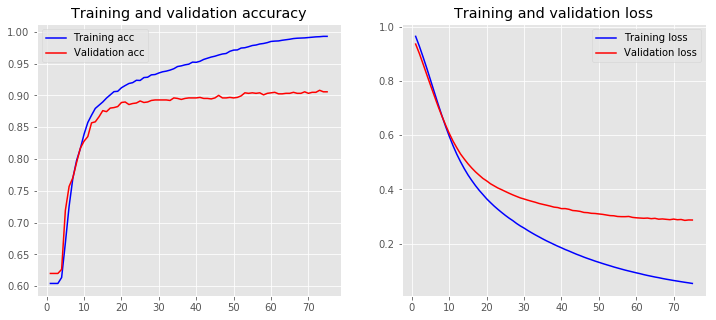

In [280]:
plt.style.use('ggplot')
plot_history(history)